In [1]:
import glob, os, sys, random
import numpy as np
from keras.preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Using TensorFlow backend.


In [2]:
#static
DATASET_PATH = '/home/gustavo/workspace/datasets/pti/PTI01/'
IMG_WIDTH = 640
IMG_HEIGHT = 480
SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)
BATCH_SIZE = 2
EPOCHS = 2
TRAIN_SPLIT = 0.5 # amount of the dataset used for training.
SHUFFLE = True

In [3]:
image_list_check = glob.glob(os.path.join(DATASET_PATH, '**/*.jpg'), recursive=True)
if SHUFFLE:
    random.shuffle(image_list_check)

In [4]:
image_path_list = []
gt_list = []
for img in image_list_check:
    label_path = img.replace('.jpg','.txt')

    if not os.path.exists(label_path):
        print('Image has no label file: {}'.format(img))
    else:
        image_path_list.append(img)

        with open(label_path) as f:
            bboxes = []
            for line in f:
                #expecting yolo annotation format.
                data = [float(t.strip()) for t in line.split()]
                if data[0] == 0.0: #pedestrian
                    data.pop(0) # remove class
                    bboxes.append(data)
            gt_list.append(bboxes)

Y = np.array(gt_list)
# Y = np.array(gt_list).reshape(len(gt_list), -1)
del image_list_check
dataset_size = len(image_path_list)
print('Loaded {} img paths and {} gts'.format(dataset_size,len(gt_list)))

Loaded 7927 img paths and 7927 gts


In [5]:
import cv2

X = []

for i,img_path in enumerate(image_path_list):
    if i > 100:
        break
    im = load_img(img_path, grayscale=False)
    
    X.append(img_to_array(im).reshape(-1))
    
#     im = cv2.resize(img_to_array(im), (416,416))
#     X.append(im.reshape(-1))

print(X[0].shape)
X = np.array(X)
print(X.shape)
t_slice = int(TRAIN_SPLIT * len(X))

train_X = np.array(X[:t_slice])

pool_train_Y = np.array(Y[:t_slice])
train_Y = np.zeros((len(pool_train_Y), 1, 4))
train_Y.shape
for i in range(t_slice):
    y = pool_train_Y[i]
    if len(y) >= 1:
        train_Y[i][0] = y[0]
    else:
        print("image with no bboxes")
   
train_Y = train_Y.reshape(len(pool_train_Y), -1)

print('train_X',train_X.shape)
print('train_Y',train_Y.shape)
print(train_Y[0])

test_X = np.array(X[t_slice:])

# test_Y = np.array(Y[t_slice:len(X)])

pool_test_Y = np.array(Y[t_slice:len(X)])
test_Y = np.zeros((len(pool_test_Y), 1, 4))
for i in range(t_slice):
    y = pool_test_Y[i]
    if len(y) >= 1:
        test_Y[i][0] = y[0]
    else:
        print("image with no bboxes")

test_Y = test_Y.reshape(len(pool_test_Y), -1)

print('test_X',test_X.shape)
print('test_Y',test_Y.shape)

print('Train/Test: {}/{}'.format(len(train_X),len(test_X)))

test_img = image_path_list[t_slice:]
test_bboxes = gt_list[t_slice:]

(921600,)
(101, 921600)
image with no bboxes
image with no bboxes
train_X (50, 921600)
train_Y (50, 4)
[ 0.37890625  0.70520833  0.2265625   0.40208333]
image with no bboxes
test_X (51, 921600)
test_Y (51, 4)
Train/Test: 50/51


In [6]:
def convertYoloAnnotToCoord(yolo_annot):
    
    w = yolo_annot[2] * IMG_WIDTH
    h = yolo_annot[3] * IMG_HEIGHT
    
    x = (yolo_annot[0] * IMG_WIDTH) - (w/2)
    y = (yolo_annot[1] * IMG_HEIGHT) - (h/2)
    
    return [x,y,w,h]

[120.0, 134.99999999999997, 111.00000000000001, 239.0]
[561.0, 153.99999999999997, 79.0, 182.0]
[195.0, 2.0, 16.0, 47.0]


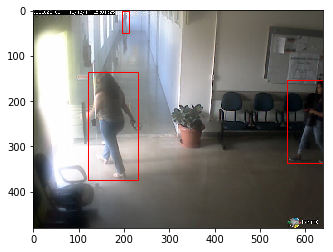

In [7]:
rand_img_idx = random.randint(0,len(X)-1)

im = load_img(image_path_list[rand_img_idx], grayscale=False)
plt.imshow(array_to_img(im))
for bbox in gt_list[rand_img_idx]:
    bbox = convertYoloAnnotToCoord(bbox)
    print(bbox)
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [10]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD
model = Sequential([
        Dense(200, input_dim=train_X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.2), 
        Dense(4)
    ])

# model = Sequential([
#     Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False, input_dim=train_X.shape[-1]),
#     BatchNormalization(name='norm_1'),
#     LeakyReLU(alpha=0.1),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dense(4)
# ])        
model.compile('adadelta', 'mse')

model.summary()

print(train_X.shape, train_Y.shape)
print(train_Y[0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               184320200 
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 804       
Total params: 184,321,004
Trainable params: 184,321,004
Non-trainable params: 0
_________________________________________________________________
(50, 921600) (50, 4)
[ 0.37890625  0.70520833  0.2265625   0.40208333]


In [11]:
from keras.models import load_model

model_name = 'model.h5'

if os.path.exists('model.h5'):
    print('Loading pre-existing model from disk.')
    model = load_model(model_name)
else:
    print('Training...')
    model.fit(train_X, train_Y, validation_split=0.2, epochs=EPOCHS, verbose=2)
    model.save(model_name)


Train on 40 samples, validate on 10 samples
Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[921600,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=9899102, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_1/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gustavo/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/gustavo/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/gustavo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gustavo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/gustavo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/gustavo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/gustavo/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gustavo/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gustavo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gustavo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gustavo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/gustavo/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5e105c93f67c>", line 9, in <module>
    Dense(4)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/models.py", line 441, in __init__
    self.add(layer)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/models.py", line 497, in add
    layer(x)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/layers/core.py", line 864, in build
    constraint=self.kernel_constraint)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 413, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/initializers.py", line 217, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/gustavo/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3838, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_random_ops.py", line 672, in random_uniform
    name=name)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/gustavo/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[921600,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=9899102, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
pred_y = model.predict(test_X[:1])
pred_bboxes = pred_Y[:1] * img_size
print(pred_bboxes, pred_bboxes.shape)
# pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
# pred_bboxes.shape